# CNN

## Importing libraries

In [3]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Rescaling, Dense, Conv2DTranspose, UpSampling2D
import numpy as np
import matplotlib.pyplot as plt

## Importing the dataset

In [4]:
def processData(type):
    subset = "training" if type == "train" else "validation"
    path = "./CIFAR10/" + "Train/" if type == "train" else "./CIFAR10/" + "Test/"
    data = tf.keras.utils.image_dataset_from_directory(
      path,
      validation_split=0,
      # subset=subset,
      seed=123,
      color_mode='grayscale',
      image_size=(28, 28),
      batch_size=8)
    normLayer = Rescaling(1./255)
    normedData = data.map(lambda x, y: (normLayer(x), tf.one_hot(y, 10)))
    return normedData
def getData():
  return processData("train"), processData("test")

In [5]:
def getAltData():
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
    # Normalize pixel values to be between 0 and 1
    train_images, test_images = np.mean(train_images, axis=3) / 255.0, np.mean(test_images, axis=3) / 255.0
    return train_images, test_images

In [6]:
train_data, test_data = getData()

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


## Creating the model

In [7]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    
    self.conv1 = Conv2D(32, 5, activation='relu')
    self.maxpool1 = MaxPool2D(2)

    self.conv2 = Conv2D(64, 5, activation='relu')
    self.maxpool2 = MaxPool2D(2)
    
    self.flatten = Flatten()
    self.d1 = Dense(1024, activation='relu')
    self.d2 = Dense(10)

  def call(self, x, training = False):
    x = self.conv1(x)
    x = self.maxpool1(x)

    x = self.conv2(x)
    x = self.maxpool2(x)
    
    x = self.flatten(x)
    x = self.d1(x)
    x = self.d2(x)

    return x

# Create an instance of the model
model = MyModel()

In [8]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

In [10]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [11]:
@tf.function
def train_step(x_train_batch, y_train_batch):
    with tf.GradientTape() as tape:
        pred = model(x_train_batch, training = True)
        loss_val = loss(y_train_batch, pred)

    grad = tape.gradient(loss_val, model.trainable_variables)
    
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    train_loss(loss_val)
    train_accuracy(y_train_batch, pred)

In [12]:
@tf.function
def test_step(x_test_batch, y_test_batch):
    pred = model(x_test_batch)
    loss_val = loss(y_test_batch, pred)

    test_loss(loss_val)
    test_accuracy(y_test_batch, pred)  

In [13]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def summary(x, n):
    summ = {"_min": tf.reduce_min(x), "_max": tf.reduce_max(x), "_mean": tf.reduce_mean(x), "_std": tf.math.reduce_std(x)}
    for s in summ:
        tf.summary.scalar(n+s, summ[s])
    tf.summary.histogram(n+"_hist", x)

In [14]:
test_summary_writer = tf.summary.create_file_writer("./cifar_logs/test/")

In [15]:
for epoch in range(30):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for x_train_batch, y_train_batch in train_data:
        train_step(x_train_batch, y_train_batch)

    for x_test_batch, y_test_batch in test_data:
        test_step(x_test_batch, y_test_batch)
        
    for x_test_batch, y_test_batch in test_data:
        with test_summary_writer.as_default(epoch):
            tf.summary.scalar('loss', train_loss.result())
            i = 1
            for x in [model.conv1(x_test_batch), 
            model.conv2(model.maxpool1(model.conv1(x_test_batch)))]:
                summary(x, str(i) + namestr(x, locals())[0])
                i += 1
        break
    print("Epoch %d: Training loss = %.4f; Training Accuracy: %.4f; Test loss: %.4f; Test Accuracy: %.4f;" 
    % (epoch, train_loss.result().numpy(),
     train_accuracy.result().numpy(),
     test_loss.result().numpy(),
     test_accuracy.result().numpy()))


Epoch 0: Training loss = 1.8753; Training Accuracy: 0.3133; Test loss: 1.6622; Test Accuracy: 0.3890;
Epoch 1: Training loss = 1.5624; Training Accuracy: 0.4414; Test loss: 1.4893; Test Accuracy: 0.4540;
Epoch 2: Training loss = 1.3843; Training Accuracy: 0.5152; Test loss: 1.3937; Test Accuracy: 0.5030;
Epoch 3: Training loss = 1.2573; Training Accuracy: 0.5611; Test loss: 1.3521; Test Accuracy: 0.5230;
Epoch 4: Training loss = 1.1358; Training Accuracy: 0.5994; Test loss: 1.3736; Test Accuracy: 0.5040;
Epoch 5: Training loss = 1.0190; Training Accuracy: 0.6438; Test loss: 1.3095; Test Accuracy: 0.5260;
Epoch 6: Training loss = 0.8954; Training Accuracy: 0.6865; Test loss: 1.3185; Test Accuracy: 0.5350;
Epoch 7: Training loss = 0.7776; Training Accuracy: 0.7295; Test loss: 1.3586; Test Accuracy: 0.5260;
Epoch 8: Training loss = 0.6402; Training Accuracy: 0.7817; Test loss: 1.4152; Test Accuracy: 0.5360;
Epoch 9: Training loss = 0.5139; Training Accuracy: 0.8312; Test loss: 1.4659; Tes

In [54]:
for layer in model.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)
    break


conv2d (5, 5, 1, 32)


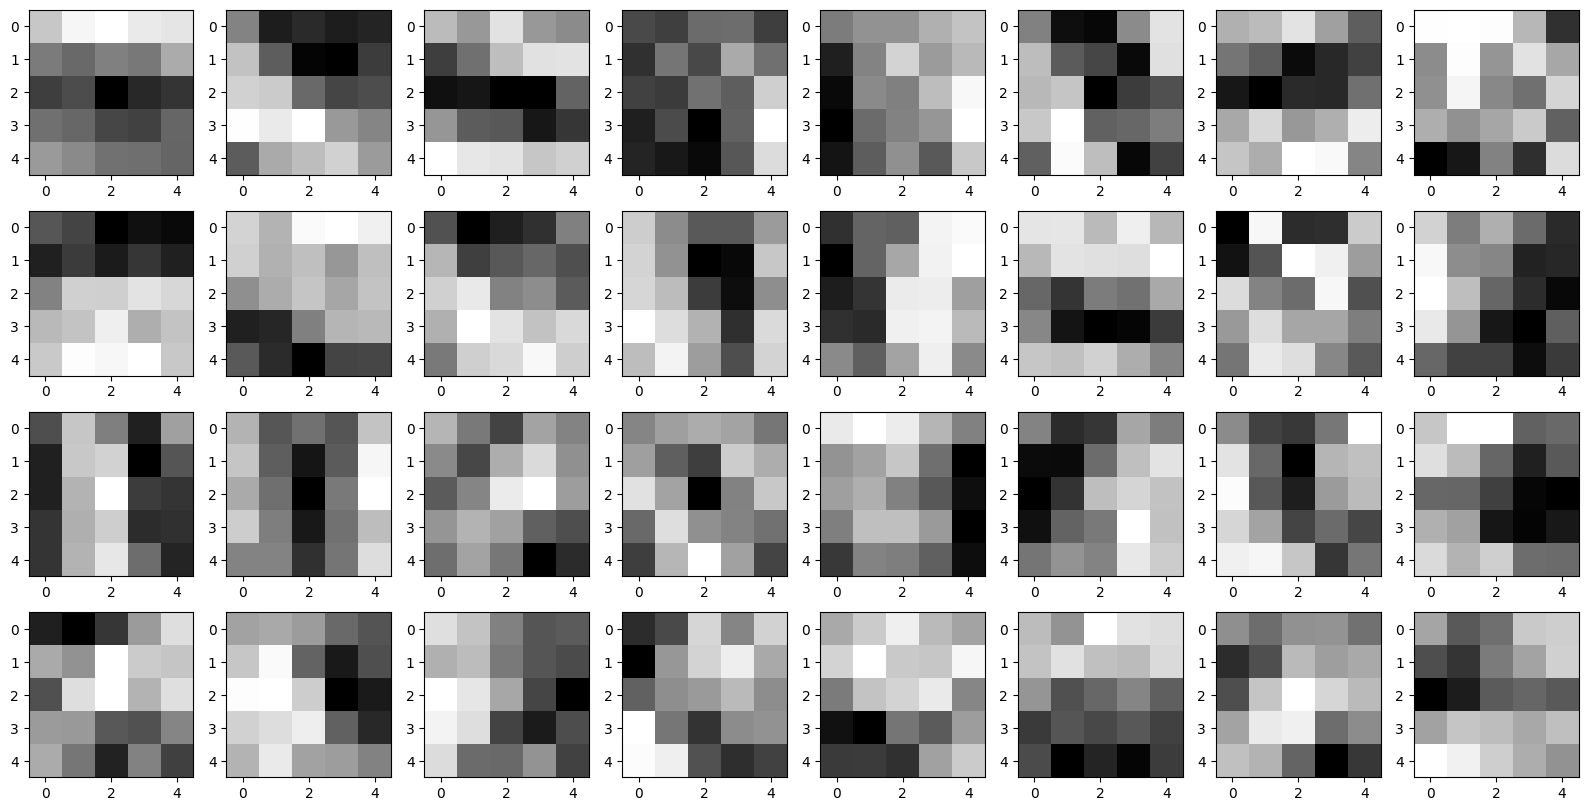

In [56]:
fig = plt.figure(figsize=(20,10))
for i in range(32):
    fmin, fmax = filters[:,:,:,i].min(), filters[:,:,:,i].max()
    norm_filters = (filters[:,:,:,i] - fmin)/(fmax - fmin)

    plt.subplot(4, 8, i+1)
    plt.imshow(filters[:,:,:,i], cmap="gray")

In [117]:
def reshapeValues(layer):
    res = []
    for x in layer:
        new_shape = []
        y = None
        for p in x.shape:
            if y:
                new_shape.append(p)
                new_shape.append(y)
                y = None
            else:
                y = p
        if y:
            new_shape.append(y)
        res.append(tf.reshape(x, new_shape))
    return res

In [50]:
w1 = model.get_weights()[0]
w1.shape
w2 = model.get_weights()[2]
w2.shape

(5, 5, 32, 64)

In [65]:
w1_index = np.argmax(tf.reduce_sum(tf.math.square(tf.norm(
    w1, ord='euclidean', axis=[0, 1]
)), axis=0))
w1_max = np.zeros(w1.shape)
w1_max[:,:,:,w1_index] = w1[:,:,:,w1_index]

w2_index = np.argmax(tf.reduce_sum(tf.math.square(tf.norm(
    w2, ord='euclidean', axis=[0, 1]
)), axis=0))
w2_max = np.zeros(w2.shape)
w2_max[:,:,:,w2_index] = w2[:,:,:,w2_index]

In [20]:
class DeMyModel(Model):
  def __init__(self, model):
    super(DeMyModel, self).__init__()
    self.deconv1 = Conv2DTranspose(1, 5, activation='relu', weights=[model.get_weights()[0], tf.zeros((1,))], name="deconv1")
    self.un_pool1 = UpSampling2D(2)

    self.deconv2 = Conv2DTranspose(32, 5, activation='relu', weights=[model.get_weights()[2], tf.zeros((32,))], name="deconv2")
    self.un_pool2 = UpSampling2D(2)

  def call(self, x, depth = 2, training = False):
    
    if depth == 2:
      x = self.un_pool2(x)
      x = self.deconv2(x)

    x = self.un_pool1(x)
    x = self.deconv1(x)
    
    return x

# Create an instance of the model
demodel = DeMyModel(model)
# demodel.compile()
# demodel.layers[0].set_weights(model.get_weights()[:2])

In [133]:
def max_activation(w1, n=1):
    w1_norm = tf.norm(
        w1, ord='euclidean', axis=[1, 2]
    )
    w1_index = np.argpartition(tf.squeeze(w1_norm), -n)[-n:]
    print(w1_index)
    w1_max = np.zeros(w1.shape)
    for i in w1_index:
        w1_max[:,:,:,i] = w1[:,:,:,i]
    return w1_max

[28]
[28]
[28]
[28]
[28]
[28]
[28]
[27]
[ 7 27 28]
[27 12 28]
[12 28  7]
[30 27 28]
[27 28  7]
[12 27 28]
[30 27 28]
[12 27 28]


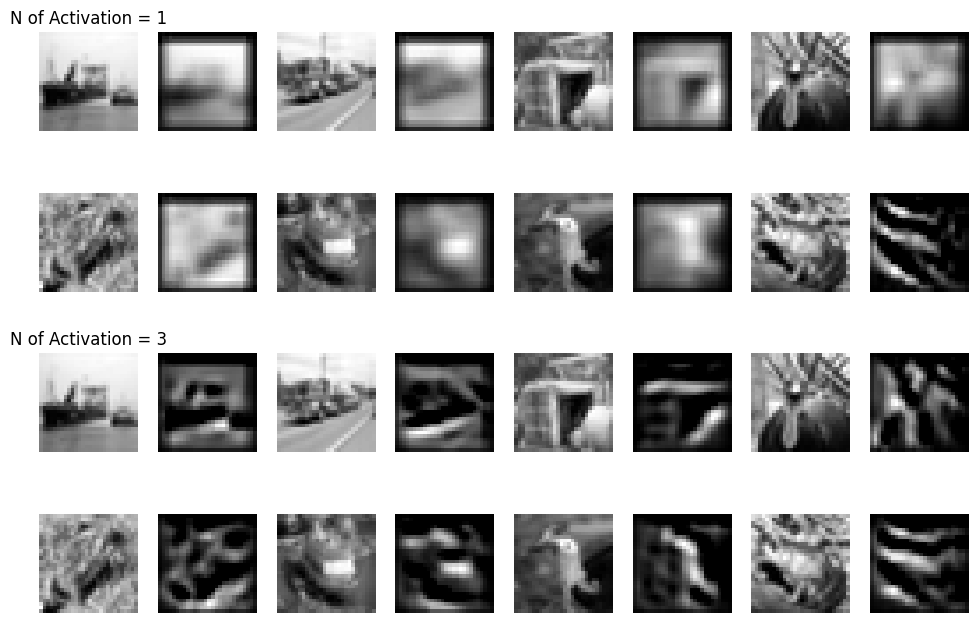

In [156]:
for x_data, y_data in train_data:
    # print(model.maxpool1(model.conv1(x_data,)).shape)
    # break
    # rec = demodel(max_activation(model.maxpool1(model.conv1(x_data,))), depth=1)    
    
    fig = plt.figure(figsize=(12, 8))
    
    title = True
    for x in range(len(x_data)):    
        rec = demodel(max_activation(model.maxpool1(model.conv1(tf.expand_dims(x_data[x], axis=0),)), 1), depth=1)
        plt.subplot(4, 8, 2*x+1)
        plt.axis('off')
        plt.imshow(x_data[x], cmap="gray")
        if title:
            plt.title(str("N of Activation = 1"))
            title = False

        img = rec[0]
        imgmin, imgmax = img.numpy().min(), img.numpy().max()
        norm_img = (img.numpy() - imgmin)/(imgmax - imgmin)
        plt.subplot(4, 8, 2*x+2)
        plt.axis('off')
        plt.imshow(norm_img, cmap="gray")
    
    title = True
    for x in range(len(x_data)):    
        rec = demodel(max_activation(model.maxpool1(model.conv1(tf.expand_dims(x_data[x], axis=0),)), 3), depth=1)
        plt.subplot(4, 8, 16+2*x+1)
        plt.axis('off')
        plt.imshow(x_data[x], cmap="gray")
        if title:
            plt.title(str("N of Activation = 3"))
            title = False
        img = rec[0]
        imgmin, imgmax = img.numpy().min(), img.numpy().max()
        norm_img = (img.numpy() - imgmin)/(imgmax - imgmin)
        plt.subplot(4, 8, 16+2*x+2)
        plt.axis('off')
        plt.imshow(norm_img, cmap="gray")
    break

[35]
[15]
[30]
[35]
[35]
[14]


C:\Users\heman\AppData\Local\Temp\ipykernel_9100\2966778752.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(6, 8, 2*x+1)


[35]
[45]
[51 20 35]
[35 62 15]
[42 49 30]
[48 35 32]
[27 35 42]
[21 59 14]
[60 48 35]
[11 28 45]
[ 2 11 50 48 20 60 35 42 51]
[41 30 54 48 39 49 15 62 35]
[17 43 15 54 35 10 42 49 30]
[60 51 26 30 59 20 48 35 32]
[63 27 50 35 42 60 61 62 51]
[27 14 21 35 59 32  1 62 10]
[14 10 27 62 24 32 60 35 48]
[55 48 28 35 37 19 44 11 45]


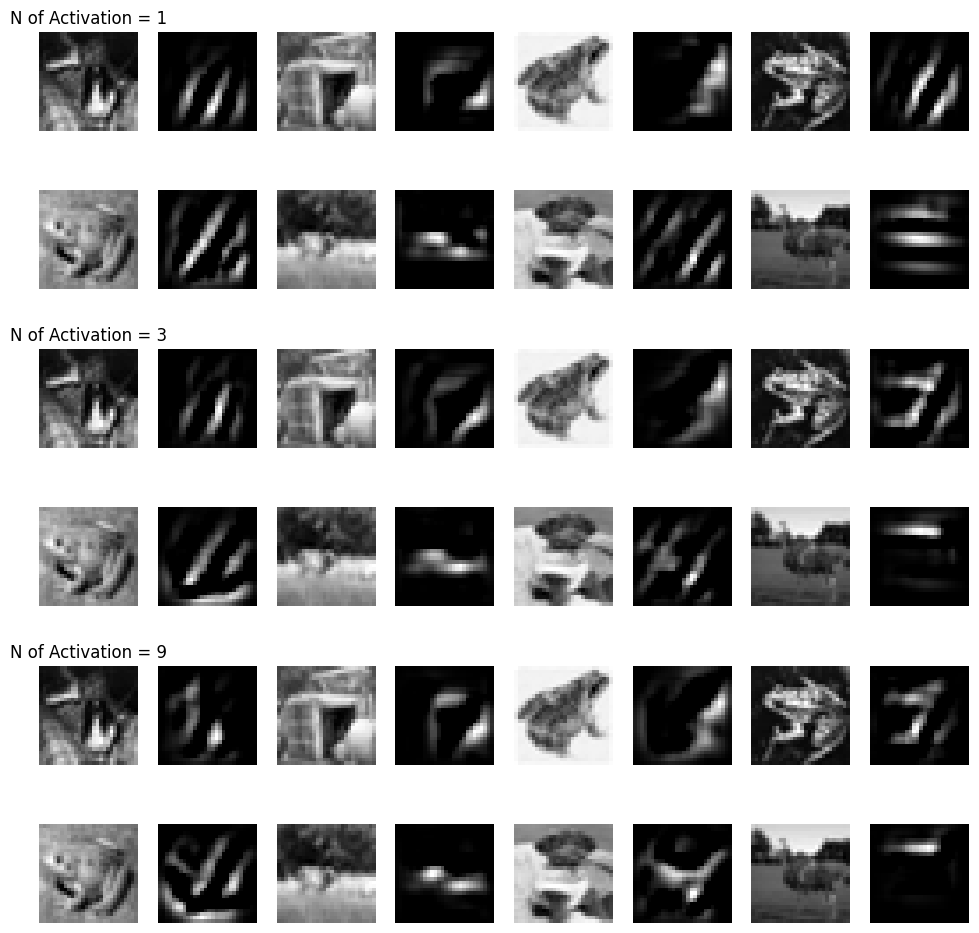

In [157]:
for x_data, y_data in train_data:
    # rec = demodel(max_activation(model.maxpool2(model.conv2(model.maxpool1(model.conv1(x_data))))))    
    
    fig = plt.figure(figsize=(12, 12))
    plt.axis('off')

    title = True
    for x in range(len(x_data)):    
        rec = demodel(max_activation(model.maxpool2(model.conv2(model.maxpool1(model.conv1(tf.expand_dims(x_data[x], axis=0),)))), 1), depth=2)
        plt.subplot(6, 8, 2*x+1)
        plt.imshow(x_data[x], cmap="gray")
        plt.axis('off')

        if title:
            plt.title(str("N of Activation = 1"))
            title = False

        img = rec[0]
        imgmin, imgmax = img.numpy().min(), img.numpy().max()
        norm_img = (img.numpy() - imgmin)/(imgmax - imgmin)
        plt.subplot(6, 8, 2*x+2)
        plt.axis('off')
        plt.imshow(norm_img, cmap="gray")

    title = True
    for x in range(len(x_data)):    
        rec = demodel(max_activation(model.maxpool2(model.conv2(model.maxpool1(model.conv1(tf.expand_dims(x_data[x], axis=0),)))), 3), depth=2)
        plt.subplot(6, 8, 16+2*x+1)
        plt.axis('off')
        plt.imshow(x_data[x], cmap="gray")

        if title:
            plt.title(str("N of Activation = 3"))
            title = False

        img = rec[0]
        imgmin, imgmax = img.numpy().min(), img.numpy().max()
        norm_img = (img.numpy() - imgmin)/(imgmax - imgmin)
        plt.subplot(6, 8, 16+2*x+2)
        plt.axis('off')
        plt.imshow(norm_img, cmap="gray")
    
    title = True
    for x in range(len(x_data)):    
        rec = demodel(max_activation(model.maxpool2(model.conv2(model.maxpool1(model.conv1(tf.expand_dims(x_data[x], axis=0),)))), 9), depth=2)
        plt.subplot(6, 8, 32+2*x+1)
        plt.axis('off')
        plt.imshow(x_data[x], cmap="gray")

        if title:
            plt.title(str("N of Activation = 9"))
            title = False

        img = rec[0]
        imgmin, imgmax = img.numpy().min(), img.numpy().max()
        norm_img = (img.numpy() - imgmin)/(imgmax - imgmin)
        plt.subplot(6, 8, 32+2*x+2)
        plt.axis('off')
        plt.imshow(norm_img, cmap="gray")
    break

In [18]:
def max_activation(w1, n=1):
    w1_norm = tf.norm(
        w1, ord='euclidean', axis=[1, 2]
    )
    w1_index = np.argpartition(tf.squeeze(w1_norm), -n)[-n:]
    print(w1_index)
    res = []
    for i in range(n):
        res.append(np.zeros(w1.shape))
    j = 0
    for i in w1_index:
        res[j][:,:,:,i] = w1[:,:,:,i]
        j += 1
    return res

[ 6 27 15]
[ 6 27 15]
[31 27 15]
[25 27 15]
[31 25 15]
[ 6  5 15]
[ 6 15 27]
[31 27 15]


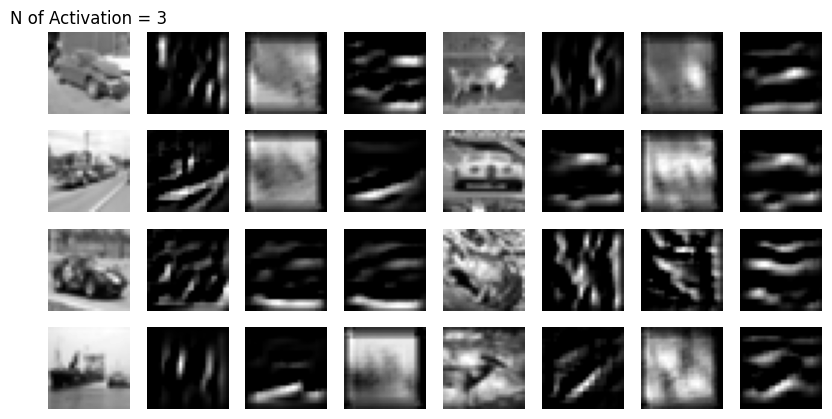

In [41]:
for x_data, y_data in train_data:
    # print(model.maxpool1(model.conv1(x_data,)).shape)
    # break
    # rec = demodel(max_activation(model.maxpool1(model.conv1(x_data,))), depth=1)    
    
    fig = plt.figure(figsize=(10, 10))
    
    # title = True
    # for x in range(len(x_data)):    
    #     rec = demodel(max_activation(model.maxpool1(model.conv1(tf.expand_dims(x_data[x], axis=0),)), 1), depth=1)
    #     plt.subplot(4, 8, 2*x+1)
    #     plt.axis('off')
    #     plt.imshow(x_data[x], cmap="gray")
    #     if title:
    #         plt.title(str("N of Activation = 1"))
    #         title = False

    #     img = rec[0]
    #     imgmin, imgmax = img.numpy().min(), img.numpy().max()
    #     norm_img = (img.numpy() - imgmin)/(imgmax - imgmin)
    #     plt.subplot(4, 8, 2*x+2)
    #     plt.axis('off')
    #     plt.imshow(norm_img, cmap="gray")
    
    title = True
    for x in range(len(x_data)):  
        j = 1  
        plt.subplot(8, 8, 4*x+1)
        plt.axis('off')
        plt.imshow(x_data[x], cmap="gray")
        if title:
            plt.title(str("N of Activation = 3"))
            title = False
        for data in max_activation(model.maxpool1(model.conv1(tf.expand_dims(x_data[x], axis=0),)), 3):
            rec = demodel(data, depth=1)
            img = rec[0]
            imgmin, imgmax = img.numpy().min(), img.numpy().max()
            norm_img = (img.numpy() - imgmin)/(imgmax - imgmin)
            plt.subplot(8, 8, 4*x+1+j)
            plt.axis('off')
            plt.imshow(norm_img, cmap="gray")
            j += 1
        # break
    break

## RNN 

## Importing Libraries

In [155]:
from tensorflow.keras.layers import SimpleRNN
import tensorflow_datasets as tfds
import tensorflow as tf

## Importing the data

In [156]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

def processData(image, y):
	image = tf.cast(image, tf.float32) / 255
	image = tf.transpose(image, [2, 0, 1])
	y = tf.one_hot(y, 10)
	return image, y

# train_data = zip(map(processData, train_images), train_labels)
# test_data = zip(map(processData, test_images), test_labels)

In [165]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

ds_train = ds_train.map(processData, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
# ds_train = ds_train.batch(8)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


ds_test = ds_test.map(processData, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
# ds_test = ds_test.batch(8)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [166]:
class RNNModel(Model):
  def __init__(self):
    super(RNNModel, self).__init__()
    
    self.rnn = SimpleRNN(10)

  def call(self, x, training = False):
    x = self.rnn(x)
    return tf.transpose(x)

# Create an instance of the model
rnn_model = RNNModel()

In [167]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [168]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

In [169]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [170]:
@tf.function
def train_step(x_train_batch, y_train_batch):
    with tf.GradientTape() as tape:
        pred = rnn_model(x_train_batch, training = True)
        loss_val = loss(y_train_batch, pred)

    grad = tape.gradient(loss_val, rnn_model.trainable_variables)
    
    optimizer.apply_gradients(zip(grad, rnn_model.trainable_variables))
    train_loss(loss_val)
    train_accuracy(y_train_batch, pred)

In [171]:
@tf.function
def test_step(x_test_batch, y_test_batch):
    pred = rnn_model(x_test_batch)
    loss_val = loss(y_test_batch, pred)

    test_loss(loss_val)
    test_accuracy(y_test_batch, pred)  

In [ ]:
for epoch in range(30):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    # train_data = zip(map(processData, train_images), train_labels)
    # test_data = zip(map(processData, test_images), test_labels)
    # for x_train_batch, y_train_batch in zip(train_images, train_labels):
    
    for x_train_batch, y_train_batch in ds_train:
        train_step(x_train_batch, y_train_batch)

    # for x_test_batch, y_test_batch in test_data:
    for x_test_batch, y_test_batch in ds_test:
        test_step(x_test_batch, y_test_batch)

    print("Epoch %d: Training loss = %.4f; Training Accuracy: %.4f; Test loss: %.4f; Test Accuracy: %.4f;" 
    % (epoch, train_loss.result().numpy(),
     train_accuracy.result().numpy(),
     test_loss.result().numpy(),
     test_accuracy.result().numpy()))


#### TF1 for RNN

In [ ]:
import tensorflow as tf 
# from tensorflow.python.ops import rnn, rnn_cell
import numpy as np 

if(tf.__version__.split('.')[0]=='2'):
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior() 


learningRate = 1e-3
trainingIters = 21000
batchSize = 16
displayStep = 600

nInput = 28#we want the input to take the 28 pixels
nSteps = 28#every 28
nHidden = 5#number of neurons for the RNN
nClasses = 10#this is MNIST so you know

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

def processData(x, y, p=True):
	x = x.astype('float32')
	x = x / 255.0
	x = np.reshape(x, (-1, nSteps, nInput))
	y = np.eye(10)[y]
	print(type(x))
	print(type(y))
	return x, y

x_train, y_train = processData(train_images, train_labels)
x_test, y_test = processData(test_images, test_labels)

x = tf.placeholder('float', [None, nSteps, nInput])
y = tf.placeholder('float', [None, nClasses])
weights = {
	'out': tf.Variable(tf.random_normal([nHidden, nClasses]))
}

biases = {
	'out': tf.Variable(tf.random_normal([nClasses]))
}

def RNN(x, weights, biases):
	x = tf.transpose(x, [1,0,2])
	x = tf.reshape(x, [-1, nInput])
	x = tf.split(x, nSteps, 0) #configuring so you can get it as needed for the 28 pixels

	lstmCell = tf.nn.rnn_cell.BasicRNNCell(nHidden, activation="relu")#find which lstm to use in the documentation

	outputs, states = tf.nn.static_rnn(lstmCell, x, dtype=tf.float32) #for the rnn where to get the output and hidden state 

	return tf.matmul(outputs[-1], weights['out'])+ biases['out']

pred = RNN(x, weights, biases)

#optimization
#create the cost, optimization, evaluation, and accuracy
#for the cost softmax_cross_entropy_with_logits seems really good
cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y))
optimizer = tf.train.AdamOptimizer(learningRate).minimize(cost)

correctPred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32), name='accuracy')

init = tf.initialize_all_variables()


tf.summary.scalar("Loss", cost)
tf.summary.scalar("Accuracy", accuracy)
summary_op_train = tf.summary.merge_all()
summary_op_test = tf.summary.merge_all()

with tf.Session() as sess:
	summary_writer_train = tf.summary.FileWriter("./logs/RNN_5n/train", sess.graph)
	summary_writer_test = tf.summary.FileWriter("./logs/RNN_5n/test", sess.graph)
	sess.run(init)
	step = 1

	while step < trainingIters:
		currbatch = step%1200
		
		batchX = x_train[step % 1200 * batchSize: (currbatch+1)*batchSize,:]
		batchY = y_train[step % 1200 * batchSize: (currbatch+1)*batchSize,:]
		
		sess.run(optimizer, feed_dict={x: batchX, y:batchY})

		if step % displayStep == 0:
			acc = accuracy.eval(feed_dict={x:batchX, y:batchY})
			loss = cost.eval(feed_dict={x:batchX, y:batchY})
			print("Iteration: " + str(step % 1200) + ", Minibatch Loss= " + \
					"{:.6f}".format(loss) + ", Training Accuracy= " + \
					"{:.2f}".format(acc))
			summary_str = sess.run(summary_op_train, feed_dict={x:batchX, y:batchY})
			summary_writer_train.add_summary(summary_str, step)
		step +=1
		if step%1200 ==0:
			print(f"Test Accuracy({step//1200}):", \
			sess.run(accuracy, feed_dict={x:x_test,y:y_test}))
			print("*"*20)
			summary_str = sess.run(summary_op_test, feed_dict={x:x_test,y:y_test})
			summary_writer_test.add_summary(summary_str, step)


#### TF1 for LSTM

In [ ]:
import tensorflow as tf 
# from tensorflow.python.ops import rnn, rnn_cell
import numpy as np 

if(tf.__version__.split('.')[0]=='2'):
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior() 


learningRate = 1e-3
trainingIters = 21000
batchSize = 16
displayStep = 600

nInput = 28#we want the input to take the 28 pixels
nSteps = 28#every 28
nHidden = 5#number of neurons for the RNN
nClasses = 10#this is MNIST so you know

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

def processData(x, y, p=True):
	x = x.astype('float32')
	x = x / 255.0
	x = np.reshape(x, (-1, nSteps, nInput))
	y = np.eye(10)[y]
	print(type(x))
	print(type(y))
	return x, y

x_train, y_train = processData(train_images, train_labels)
x_test, y_test = processData(test_images, test_labels)

x = tf.placeholder('float', [None, nSteps, nInput])
y = tf.placeholder('float', [None, nClasses])
weights = {
	'out': tf.Variable(tf.random_normal([nHidden, nClasses]))
}

biases = {
	'out': tf.Variable(tf.random_normal([nClasses]))
}

def RNN(x, weights, biases):
	x = tf.transpose(x, [1,0,2])
	x = tf.reshape(x, [-1, nInput])
	x = tf.split(x, nSteps, 0) #configuring so you can get it as needed for the 28 pixels

	lstmCell = tf.nn.rnn_cell.LSTMCell(nHidden, activation="relu")#find which lstm to use in the documentation

	outputs, states = tf.nn.static_rnn(lstmCell, x, dtype=tf.float32) #for the rnn where to get the output and hidden state 

	return tf.matmul(outputs[-1], weights['out'])+ biases['out']

pred = RNN(x, weights, biases)

#optimization
#create the cost, optimization, evaluation, and accuracy
#for the cost softmax_cross_entropy_with_logits seems really good
cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y))
optimizer = tf.train.AdamOptimizer(learningRate).minimize(cost)

correctPred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32), name='accuracy')

init = tf.initialize_all_variables()


tf.summary.scalar("Loss", cost)
tf.summary.scalar("Accuracy", accuracy)
summary_op_train = tf.summary.merge_all()
summary_op_test = tf.summary.merge_all()

with tf.Session() as sess:
	summary_writer_train = tf.summary.FileWriter("./logs/LSTM_5n/train", sess.graph)
	summary_writer_test = tf.summary.FileWriter("./logs/LSTM_5n/test", sess.graph)
	sess.run(init)
	step = 1

	while step < trainingIters:
		currbatch = step%1200
		
		batchX = x_train[step % 1200 * batchSize: (currbatch+1)*batchSize,:]
		batchY = y_train[step % 1200 * batchSize: (currbatch+1)*batchSize,:]
		
		sess.run(optimizer, feed_dict={x: batchX, y:batchY})

		if step % displayStep == 0:
			acc = accuracy.eval(feed_dict={x:batchX, y:batchY})
			loss = cost.eval(feed_dict={x:batchX, y:batchY})
			print("Iteration: " + str(step % 1200) + ", Minibatch Loss= " + \
					"{:.6f}".format(loss) + ", Training Accuracy= " + \
					"{:.2f}".format(acc))
			summary_str = sess.run(summary_op_train, feed_dict={x:batchX, y:batchY})
			summary_writer_train.add_summary(summary_str, step)
		step +=1
		if step%1200 ==0:
			print(f"Test Accuracy({step//1200}):", \
			sess.run(accuracy, feed_dict={x:x_test,y:y_test}))
			print("*"*20)
			summary_str = sess.run(summary_op_test, feed_dict={x:x_test,y:y_test})
			summary_writer_test.add_summary(summary_str, step)


TF1 for GRU

In [ ]:
import tensorflow as tf 
# from tensorflow.python.ops import rnn, rnn_cell
import numpy as np 

if(tf.__version__.split('.')[0]=='2'):
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior() 


learningRate = 1e-3
trainingIters = 21000
batchSize = 16
displayStep = 600

nInput = 28#we want the input to take the 28 pixels
nSteps = 28#every 28
nHidden = 5#number of neurons for the RNN
nClasses = 10#this is MNIST so you know

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

def processData(x, y, p=True):
	x = x.astype('float32')
	x = x / 255.0
	x = np.reshape(x, (-1, nSteps, nInput))
	y = np.eye(10)[y]
	print(type(x))
	print(type(y))
	return x, y

x_train, y_train = processData(train_images, train_labels)
x_test, y_test = processData(test_images, test_labels)

x = tf.placeholder('float', [None, nSteps, nInput])
y = tf.placeholder('float', [None, nClasses])
weights = {
	'out': tf.Variable(tf.random_normal([nHidden, nClasses]))
}

biases = {
	'out': tf.Variable(tf.random_normal([nClasses]))
}

def RNN(x, weights, biases):
	x = tf.transpose(x, [1,0,2])
	x = tf.reshape(x, [-1, nInput])
	x = tf.split(x, nSteps, 0) #configuring so you can get it as needed for the 28 pixels

	lstmCell = tf.nn.rnn_cell.GRUCell(nHidden, activation="relu")#find which lstm to use in the documentation

	outputs, states = tf.nn.static_rnn(lstmCell, x, dtype=tf.float32) #for the rnn where to get the output and hidden state 

	return tf.matmul(outputs[-1], weights['out'])+ biases['out']

pred = RNN(x, weights, biases)

#optimization
#create the cost, optimization, evaluation, and accuracy
#for the cost softmax_cross_entropy_with_logits seems really good
cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y))
optimizer = tf.train.AdamOptimizer(learningRate).minimize(cost)

correctPred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32), name='accuracy')

init = tf.initialize_all_variables()


tf.summary.scalar("Loss", cost)
tf.summary.scalar("Accuracy", accuracy)
summary_op_train = tf.summary.merge_all()
summary_op_test = tf.summary.merge_all()

with tf.Session() as sess:
	summary_writer_train = tf.summary.FileWriter("./logs/GRU_5n/train", sess.graph)
	summary_writer_test = tf.summary.FileWriter("./logs/GRU_5n/test", sess.graph)
	sess.run(init)
	step = 1

	while step < trainingIters:
		currbatch = step%1200
		
		batchX = x_train[step % 1200 * batchSize: (currbatch+1)*batchSize,:]
		batchY = y_train[step % 1200 * batchSize: (currbatch+1)*batchSize,:]
		
		sess.run(optimizer, feed_dict={x: batchX, y:batchY})

		if step % displayStep == 0:
			acc = accuracy.eval(feed_dict={x:batchX, y:batchY})
			loss = cost.eval(feed_dict={x:batchX, y:batchY})
			print("Iteration: " + str(step % 1200) + ", Minibatch Loss= " + \
					"{:.6f}".format(loss) + ", Training Accuracy= " + \
					"{:.2f}".format(acc))
			summary_str = sess.run(summary_op_train, feed_dict={x:batchX, y:batchY})
			summary_writer_train.add_summary(summary_str, step)
		step +=1
		if step%1200 ==0:
			print(f"Test Accuracy({step//1200}):", \
			sess.run(accuracy, feed_dict={x:x_test,y:y_test}))
			print("*"*20)
			summary_str = sess.run(summary_op_test, feed_dict={x:x_test,y:y_test})
			summary_writer_test.add_summary(summary_str, step)
